In [1]:
import os 
from PIL import Image
from io import BytesIO
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.models import Model

In [3]:
with open('C:/Users/User/Pictures/content.jpg', 'rb') as picture:
    content = Image.open(BytesIO(picture.read())).resize((240, 240))
content = np.array(content)
content

array([[[88, 88, 88],
        [89, 89, 89],
        [89, 89, 89],
        ...,
        [87, 87, 87],
        [87, 87, 87],
        [87, 87, 87]],

       [[87, 87, 87],
        [88, 88, 88],
        [89, 89, 89],
        ...,
        [87, 87, 87],
        [87, 87, 87],
        [87, 87, 87]],

       [[87, 87, 87],
        [87, 87, 87],
        [88, 88, 88],
        ...,
        [87, 87, 87],
        [87, 87, 87],
        [87, 87, 87]],

       ...,

       [[78, 78, 78],
        [78, 78, 78],
        [78, 78, 78],
        ...,
        [ 4,  4,  4],
        [64, 64, 64],
        [80, 80, 80]],

       [[78, 78, 78],
        [78, 78, 78],
        [78, 78, 78],
        ...,
        [ 0,  0,  0],
        [50, 50, 50],
        [79, 79, 79]],

       [[78, 78, 78],
        [78, 78, 78],
        [78, 78, 78],
        ...,
        [ 0,  0,  0],
        [42, 42, 42],
        [83, 83, 83]]], dtype=uint8)

In [4]:
with open('C:/Users/User/Pictures/cat_style.jpg', 'rb') as picture:
    style = Image.open(BytesIO(picture.read())).resize((240, 240))
style = np.array(style)
style

array([[[113, 116, 127],
        [112, 110, 129],
        [110, 110, 131],
        ...,
        [ 37,  55, 100],
        [ 67,  87, 120],
        [154, 175, 189]],

       [[ 26,  25,  50],
        [ 20,  19,  53],
        [ 22,  20,  58],
        ...,
        [ 37,  49, 106],
        [ 40,  52, 106],
        [ 38,  65, 109]],

       [[ 29,  25,  52],
        [ 23,  23,  55],
        [ 27,  22,  56],
        ...,
        [ 32,  47, 100],
        [ 36,  54, 106],
        [ 35,  56, 104]],

       ...,

       [[ 25,  48, 105],
        [ 24,  48, 107],
        [ 22,  47, 110],
        ...,
        [ 14,  77, 178],
        [ 63,  89, 134],
        [124, 144, 153]],

       [[ 32,  47, 101],
        [ 25,  46, 104],
        [ 19,  46, 108],
        ...,
        [ 54,  88, 139],
        [ 75,  85, 103],
        [167, 189, 194]],

       [[ 53,  68, 103],
        [ 42,  57, 103],
        [ 45,  62, 106],
        ...,
        [ 85,  86,  91],
        [ 89, 101, 111],
        [209, 225, 228]]

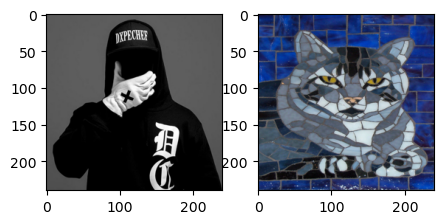

In [5]:
fig = plt.figure(figsize=(5,5))
ax = fig.subplots(1, 2)
ax[0].imshow(content)
ax[1].imshow(style)
plt.show()

In [6]:
x_img = preprocess_input( np.expand_dims(content, axis=0) )
x_style = preprocess_input(np.expand_dims(style, axis=0))

In [7]:
def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
    if len(x.shape) != 3:
        raise ValueError("Invalid input to deprocessing image")

    # perform the inverse of the preprocessing step
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [8]:
vgg = VGG19(include_top=False, weights='imagenet')
vgg.trainable = False 

# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer we are interested in
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [9]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [11]:
style_outputs = [vgg.get_layer(name).output for name in style_layers]
content_outputs = [vgg.get_layer(name).output for name in content_layers]
model_outputs = style_outputs + content_outputs

print(vgg.input)
for m in model_outputs:
    print(m)

model = Model(vgg.input, model_outputs)
for layer in model.layers:
    layer.trainable = False

print(model.summary())

KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 64), dtype=tf.float32, name=None), name='block1_conv1/Relu:0', description="created by layer 'block1_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 128), dtype=tf.float32, name=None), name='block2_conv1/Relu:0', description="created by layer 'block2_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 256), dtype=tf.float32, name=None), name='block3_conv1/Relu:0', description="created by layer 'block3_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 512), dtype=tf.float32, name=None), name='block4_conv1/Relu:0', description="created by layer 'block4_conv1'")
KerasTensor(type_spec=TensorSpec(shape=(None, None, None, 512), dtype=tf.float32, name=None), name='block5_conv1/Relu:0', description="created by layer 'block5_conv1'")
K

In [12]:
def get_feature_representations(model):
    # batch compute content and style features
    style_outputs = model(x_style)
    content_outputs = model(x_img)

    # Get the style and content feature representations from our model  
    style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
    content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
    return style_features, content_features

In [13]:
def get_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

In [14]:
def gram_matrix(input_tensor):
    # We make the image channels first 
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

In [15]:
def get_style_loss(base_style, gram_target):
    gram_style = gram_matrix(base_style)
    return tf.reduce_mean(tf.square(gram_style - gram_target))

In [18]:
@tf.function
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    style_weight, content_weight = loss_weights

    model_outputs = model(init_image)

    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]

    style_score = 0
    content_score = 0

    # Accumulate style losses from all layers
    # Here, we equally weight each contribution of each loss layer
    weight_per_style_layer = 1.0 / float(num_style_layers)
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)

    # Accumulate content losses from all layers 
    weight_per_content_layer = 1.0 / float(num_content_layers)
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)

    style_score *= style_weight
    content_score *= content_weight

    # Get total loss
    loss = style_score + content_score 
    return loss, style_score, content_score

In [21]:
num_iterations=300
content_weight=1e3
style_weight=1e-2

style_features, content_features = get_feature_representations(model)
gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]

init_image = np.copy(x_img)
init_image = tf.Variable(init_image, dtype=tf.float32)

opt = tf.compat.v1.train.AdamOptimizer(learning_rate=2, beta1=0.99, epsilon=1e-1)
iter_count = 1
best_loss, best_img = float('inf'), None
loss_weights = (style_weight, content_weight)

cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
}

norm_means = np.array([103.939, 116.779, 123.68])
min_vals = -norm_means
max_vals = 255 - norm_means
imgs = []

for i in range(num_iterations):
    with tf.GradientTape() as tape: 
        all_loss = compute_loss(**cfg)

    loss, style_score, content_score = all_loss
    grads = tape.gradient(loss, init_image)

    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)

    if loss < best_loss:
        # Update best loss and best image from total loss. 
        best_loss = loss
        best_img = deprocess_img(init_image.numpy())

        # Use the .numpy() method to get the concrete numpy array
        plot_img = deprocess_img(init_image.numpy())
        imgs.append(plot_img)
        print(f'Iteration: {i}, best loss: {best_loss:n}')

Iteration: 0, best loss: 3.60144e+08
Iteration: 1, best loss: 2.804e+08
Iteration: 2, best loss: 2.12457e+08
Iteration: 3, best loss: 1.54507e+08
Iteration: 4, best loss: 1.11593e+08
Iteration: 5, best loss: 8.49361e+07
Iteration: 6, best loss: 7.18086e+07
Iteration: 7, best loss: 6.62154e+07
Iteration: 8, best loss: 6.31788e+07
Iteration: 9, best loss: 6.06792e+07
Iteration: 10, best loss: 5.84796e+07
Iteration: 11, best loss: 5.6608e+07
Iteration: 12, best loss: 5.48685e+07
Iteration: 13, best loss: 5.30991e+07
Iteration: 14, best loss: 5.12247e+07
Iteration: 15, best loss: 4.93551e+07
Iteration: 16, best loss: 4.7651e+07
Iteration: 17, best loss: 4.61249e+07
Iteration: 18, best loss: 4.4689e+07
Iteration: 19, best loss: 4.32285e+07
Iteration: 20, best loss: 4.16724e+07
Iteration: 21, best loss: 4.00242e+07
Iteration: 22, best loss: 3.83401e+07
Iteration: 23, best loss: 3.66955e+07
Iteration: 24, best loss: 3.51618e+07
Iteration: 25, best loss: 3.37779e+07
Iteration: 26, best loss: 3

Iteration: 214, best loss: 6.47528e+06
Iteration: 215, best loss: 6.44865e+06
Iteration: 216, best loss: 6.42268e+06
Iteration: 217, best loss: 6.39726e+06
Iteration: 218, best loss: 6.37209e+06
Iteration: 219, best loss: 6.34687e+06
Iteration: 220, best loss: 6.32142e+06
Iteration: 221, best loss: 6.29576e+06
Iteration: 222, best loss: 6.26993e+06
Iteration: 223, best loss: 6.24434e+06
Iteration: 224, best loss: 6.21922e+06
Iteration: 225, best loss: 6.1947e+06
Iteration: 226, best loss: 6.17096e+06
Iteration: 227, best loss: 6.14785e+06
Iteration: 228, best loss: 6.12528e+06
Iteration: 229, best loss: 6.10299e+06
Iteration: 230, best loss: 6.08071e+06
Iteration: 231, best loss: 6.05828e+06
Iteration: 232, best loss: 6.03553e+06
Iteration: 233, best loss: 6.01242e+06
Iteration: 234, best loss: 5.98921e+06
Iteration: 235, best loss: 5.96608e+06
Iteration: 236, best loss: 5.94332e+06
Iteration: 237, best loss: 5.92111e+06
Iteration: 238, best loss: 5.8993e+06
Iteration: 239, best loss: 

best loss: 4.84021e+06


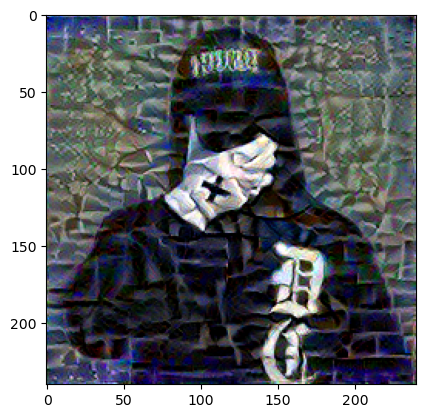

In [22]:
plt.imshow(best_img)
print(f'best loss: {best_loss:n}')